# データのロード
まずはデータを読み込んで見ましょう。csvデータの読み込みは複数のやり方がありえますが、pandasのread_csv関数はその中でも機能が豊富で、扱いやすいためこれを使います。
これを使うと、csvデータを読み込み、pandas.DataFrameにして返してくれます。

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pdp
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
#import lightgbm as lgb
from optuna.integration import lightgbm as gbm
import warnings
warnings.simplefilter('ignore')

ModuleNotFoundError: No module named 'xgboost'

In [3]:
!pip install optuna

In [4]:
#データの読み込みと前処理
import pandas as pd
train = pd.read_csv("train_data.csv", index_col='id')
test = pd.read_csv("test_data.csv", index_col='id')
game = pd.read_csv("game_info.csv")
target = train['y']
game = game.drop('Unnamed: 0',axis=1)
print(train.shape)
print(test.shape)
print(test.head())



(20400, 23)
(33808, 13)
    totalPitchingCount  B  S  O     b1     b2     b3  pitcher pitcherHand  \
id                                                                          
0                    2  1  0  0  False  False  False    遠藤 淳志           R   
1                    1  0  0  0  False  False  False  バンデンハーク           R   
2                    7  3  2  2   True  False  False     スアレス           R   
3                    1  0  0  2   True  False  False      クック           R   
4                    2  0  0  2  False  False  False    則本 昂大           R   

   batter batterHand    gameID inning  
id                                     
0    乙坂 智          L  20202564    2回表  
1   西川 遥輝          L  20202106    3回裏  
2   堂林 翔太          R  20203305    9回裏  
3   井領 雅貴          L  20202650    3回裏  
4   安達 了一          R  20202339    2回表  


In [5]:
train['y']

id
0        0
1        1
2        0
3        2
4        4
        ..
20395    2
20396    0
20397    1
20398    0
20399    1
Name: y, Length: 20400, dtype: int64

In [6]:
train = pd.merge(train, game, on='gameID')
test = pd.merge(test, game, on='gameID')

In [7]:
num_data=train.select_dtypes(include='int64')
obj_data=train.select_dtypes(include='object')
lostlist=obj_data.columns[obj_data.isnull().sum()!=0]
complist=obj_data.columns[obj_data.isnull().sum()==0]
lost_obj_data=obj_data[lostlist]
comp_obj_data=obj_data[complist]

In [8]:
train['y']

0        0
1        1
2        0
3        2
4        4
        ..
20395    2
20396    0
20397    1
20398    0
20399    1
Name: y, Length: 20400, dtype: int64

In [9]:
obj_data.isnull().sum()

pitcher                  0
pitcherHand             45
batter                   0
batterHand              45
inning                   0
pitchType                0
speed                    0
ballPositionLabel        0
ballY                    0
dir                  16758
battingType          16758
isOuts               15234
startTime                0
bottomTeam               0
topTeam                  0
place                    0
startDayTime             0
dtype: int64

In [10]:
lostlist

Index(['pitcherHand', 'batterHand', 'dir', 'battingType', 'isOuts'], dtype='object')

In [11]:
#重複データの表示
#print(train[train_data.duplicated()])

#重複データの削除
#2040-3264=
train = train.drop_duplicates()
print(train)

       totalPitchingCount  B  S  O     b1     b2     b3 pitcher pitcherHand  \
0                       1  0  0  0  False  False  False   今永 昇太           L   
1                       2  1  0  0  False  False  False   今永 昇太           L   
2                       3  1  1  0  False  False  False   今永 昇太           L   
3                       4  2  1  0  False  False  False   今永 昇太           L   
4                       5  2  2  0  False  False  False   今永 昇太           L   
...                   ... .. .. ..    ...    ...    ...     ...         ...   
20152                   2  1  0  2  False  False  False    森 唯斗           R   
20153                   3  1  1  2  False  False  False    森 唯斗           R   
20154                   4  2  1  2  False  False  False    森 唯斗           R   
20155                   5  2  2  2  False  False  False    森 唯斗           R   
20156                   6  3  2  2  False  False  False    森 唯斗           R   

      batter  ... battingType  isOuts  y startTime 

##量的変数だけで、データクレンジング
---
回帰編４を参考


**データの説明**

- `totalPitchingCount`：各打席の投球が何球目か
- `B` `S` `O`:ボールカウント、ストライクカウント、アウトカウント
- `b1` `b2` `b3`:1塁にランナーがいるか、2塁にランナーがいるか、3塁にランナーがいるか


- `pitcher`：ピッチャー名（NaNを含む）
- `pitcherHand`：右投げか左投げかdd
- `pitchType`：球種
- `pitchType`：打球方向(A-Z)

- `batter`：バッター名（NaNを含む）
- `batterHand`：右打ちか左打ちか
- `battingType`：打球種類(B:バント, G:ゴロ, P:ポップフライ, F:フライ, L:ライナー)

- `isOuts`：isOuts

- `gameID`：試合ID
- `place`：試合会場
- `inning`：イニング　一回表
- `startDayTime`：試合開始日時
- `startTime`：	試合開始時間
- `topTeam`：先攻チーム名
- `bottomTeam`：後攻チーム名
- `bgBottom`：試合ID
						

下記を削除
- 値が1つしかない量的変数
- サンプルごとに固有の値を持つ量的変数
- trainにあってtestにないカラム

In [12]:
# trainにあってtestにないカラムを削除
drop_cols = ['pitchType','speed','ballPositionLabel','ballX','ballY','dir','dist','battingType','isOuts']
train = train.drop(drop_cols, axis='columns')


In [13]:
#サンプルごとに固有の値を持つ質的変数 時系列データの削除
drop_cols = ['startDayTime','startTime']
train = train.drop(drop_cols, axis='columns')
test = test.drop(drop_cols,axis='columns')

In [14]:
train['y']

0        0
1        1
2        0
3        2
4        4
        ..
20152    2
20153    0
20154    1
20155    0
20156    1
Name: y, Length: 17136, dtype: int64

In [15]:
train.columns

Index(['totalPitchingCount', 'B', 'S', 'O', 'b1', 'b2', 'b3', 'pitcher',
       'pitcherHand', 'batter', 'batterHand', 'gameID', 'inning', 'y',
       'bottomTeam', 'bgBottom', 'topTeam', 'place', 'bgTop'],
      dtype='object')

In [16]:
test.columns

Index(['totalPitchingCount', 'B', 'S', 'O', 'b1', 'b2', 'b3', 'pitcher',
       'pitcherHand', 'batter', 'batterHand', 'gameID', 'inning', 'bottomTeam',
       'bgBottom', 'topTeam', 'place', 'bgTop'],
      dtype='object')

## 質的データの整理　欠損値がある部分

In [17]:
lostlist

Index(['pitcherHand', 'batterHand', 'dir', 'battingType', 'isOuts'], dtype='object')

In [18]:
train["pitcherHand"].value_counts()

R    12078
L     5027
Name: pitcherHand, dtype: int64

In [19]:
train["batterHand"].value_counts()

R    9019
L    8086
Name: batterHand, dtype: int64

In [20]:
train['pitcherHand'].isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
20152    False
20153    False
20154    False
20155    False
20156    False
Name: pitcherHand, Length: 17136, dtype: bool

In [21]:
#train[train['pitcherHand'].isnull()]
train[train['batterHand'].isnull()]

,totalPitchingCount,B,S,O,b1,b2,b3,pitcher,pitcherHand,batter,batterHand,gameID,inning,y,bottomTeam,bgBottom,topTeam,place,bgTop
986,1,0,0,2,True,False,True,東浜 巨,NaN,角中 勝也,NaN,20202170,3回表,1,ソフトバンク,12,ロッテ,PayPayドーム,9
987,2,0,1,2,True,False,True,東浜 巨,NaN,角中 勝也,NaN,20202170,3回表,0,ソフトバンク,12,ロッテ,PayPayドーム,9
988,3,1,1,2,True,False,True,東浜 巨,NaN,角中 勝也,NaN,20202170,3回表,1,ソフトバンク,12,ロッテ,PayPayドーム,9
2975,1,0,0,2,True,False,True,松井 裕樹,NaN,大城 滉二,NaN,20202165,1回裏,0,オリックス,11,楽天,京セラD大阪,10
2976,2,1,0,2,True,False,True,松井 裕樹,NaN,大城 滉二,NaN,20202165,1回裏,1,オリックス,11,楽天,京セラD大阪,10
2977,3,1,1,2,True,False,True,松井 裕樹,NaN,大城 滉二,NaN,20202165,1回裏,2,オリックス,11,楽天,京セラD大阪,10
3910,1,0,0,2,True,False,False,サンチェス,NaN,糸原 健斗,NaN,20202163,3回表,1,巨人,1,阪神,東京ドーム,5
3911,3,0,1,2,True,False,False,サンチェス,NaN,糸原 健斗,NaN,20202163,3回表,1,巨人,1,阪神,東京ドーム,5
3912,4,1,2,2,True,False,False,サンチェス,NaN,糸原 健斗,NaN,20202163,3回表,2,巨人,1,阪神,東京ドーム,5
3913,5,1,2,2,True,False,False,サンチェス,NaN,糸原 健斗,NaN,20202163,3回表,0,巨人,1,阪神,東京ドーム,5


In [22]:
train_test= train[train['batterHand'].isnull()]
batters= train_test['batter'].value_counts()
##Index(['高橋 光成', 'サンチェス', '山本 由伸', '松井 裕樹', '戸郷 翔征', '中田 賢一', '東浜 巨', '塩見 貴洋','二保 旭', '石川 柊太', '神戸 文也'],dtype='object')
#print(pitchers.index)
print(batters.index)


Index(['ジョーンズ', '糸原 健斗', '荻野 貴司', '角中 勝也', '大城 滉二', 'ソト', '近藤 健介', '安部 友裕',
       '金子 侑司', '森 友哉', '源田 壮亮'],
      dtype='object')


In [946]:
#ピッチャーの投げる手のnullを補完
com_train= train[train['pitcherHand'].isnull()]
for index, row in train.iterrows():    
    #print(index, row)
    #print(row.at['pitcher'] )
    if row.at['pitcher'] in pitchers.index:
        if row.at['pitcher'] in ['松井 裕樹','塩見 貴洋']:
            #print(row.at['pitcher'])
            train.at['pitcherHand'] ='L'
           # print(row.at['pitcherHand'])
        if row.at['pitcher'] in ['神戸 文也','石川 柊太','高橋 光成','中田 賢一','サンチェス','山本 由伸','戸郷 翔征','東浜 巨','二保 旭']:
            #print(row.at['pitcher'])
            train.at['pitcherHand'] ='R'
            #print(row.at['pitcherHand'])
#for rt in com_train:
#    print(rt)

In [947]:
#バッターの打つ手のnullを補完
# yにbatterHand Lが混ざってしまう。
train_test= train[train['batterHand'].isnull()]
batters= train_test['batter'].value_counts()
com_train= train[train['batter'].isnull()]

for index, row in train.iterrows():    
    if row.at['batter'] in batters.index:
        if row.at['batter'] in ['糸原 健斗','角中 勝也','近藤 健介','安部 友裕','金子 侑司','森 友哉','源田 壮亮']:
            train.at['batterHand'] ='L'
        if row.at['batter'] in ['荻野 貴司','ジョーンズ','大城 滉二','ソト']:
            train.at['batterHand'] ='R'


In [23]:
train['y']

0        0
1        1
2        0
3        2
4        4
        ..
20152    2
20153    0
20154    1
20155    0
20156    1
Name: y, Length: 17136, dtype: int64

In [24]:
imp_data.isnull().sum()

NameError: name 'imp_data' is not defined

In [1016]:
train['y']

0        0
1        1
2        0
3        2
4        4
        ..
20152    2
20153    0
20154    1
20155    0
20156    1
Name: y, Length: 17136, dtype: int64

In [25]:
del train['pitcherHand']
del test['pitcherHand']
del train['batterHand']
del test['batterHand']

In [26]:

imp_data = train
imp_data

,totalPitchingCount,B,S,O,b1,b2,b3,pitcher,batter,gameID,inning,y,bottomTeam,bgBottom,topTeam,place,bgTop
0,1,0,0,0,False,False,False,今永 昇太,ピレラ,20202173,1回表,0,DeNA,3,広島,横浜,6
1,2,1,0,0,False,False,False,今永 昇太,ピレラ,20202173,1回表,1,DeNA,3,広島,横浜,6
2,3,1,1,0,False,False,False,今永 昇太,ピレラ,20202173,1回表,0,DeNA,3,広島,横浜,6
3,4,2,1,0,False,False,False,今永 昇太,ピレラ,20202173,1回表,2,DeNA,3,広島,横浜,6
4,5,2,2,0,False,False,False,今永 昇太,ピレラ,20202173,1回表,4,DeNA,3,広島,横浜,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20152,2,1,0,2,False,False,False,森 唯斗,大田 泰示,20202118,9回裏,2,日本ハム,8,ソフトバンク,札幌ドーム,12
20153,3,1,1,2,False,False,False,森 唯斗,大田 泰示,20202118,9回裏,0,日本ハム,8,ソフトバンク,札幌ドーム,12
20154,4,2,1,2,False,False,False,森 唯斗,大田 泰示,20202118,9回裏,1,日本ハム,8,ソフトバンク,札幌ドーム,12
20155,5,2,2,2,False,False,False,森 唯斗,大田 泰示,20202118,9回裏,0,日本ハム,8,ソフトバンク,札幌ドーム,12


In [27]:
test

,totalPitchingCount,B,S,O,b1,b2,b3,pitcher,batter,gameID,inning,bottomTeam,bgBottom,topTeam,place,bgTop
0,2,1,0,0,False,False,False,遠藤 淳志,乙坂 智,20202564,2回表,広島,6,DeNA,マツダスタジアム,3
1,4,1,2,1,False,False,False,京山 将弥,ピレラ,20202564,3回裏,広島,6,DeNA,マツダスタジアム,3
2,2,0,1,2,True,False,False,京山 将弥,大盛 穂,20202564,4回裏,広島,6,DeNA,マツダスタジアム,3
3,5,2,2,1,False,False,False,京山 将弥,鈴木 誠也,20202564,5回裏,広島,6,DeNA,マツダスタジアム,3
4,1,0,0,0,False,False,False,遠藤 淳志,梶谷 隆幸,20202564,1回表,広島,6,DeNA,マツダスタジアム,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33803,3,1,1,2,True,True,False,吉見 一起,吉川 尚輝,20202097,1回裏,巨人,1,中日,東京ドーム,4
33804,7,3,2,2,False,False,False,ゴンサレス,重信 慎之介,20202097,6回裏,巨人,1,中日,東京ドーム,4
33805,1,0,0,1,False,True,False,祖父江 大輔,北村 拓己,20202097,7回裏,巨人,1,中日,東京ドーム,4
33806,1,0,0,1,True,False,False,田口 麗斗,阿部 寿樹,20202097,2回表,巨人,1,中日,東京ドーム,4


In [28]:
with open('imp_data.csv', mode='wb') as f:
    pickle.dump(imp_data, f)

In [29]:
with open('imp_data.csv', mode='rb') as f:
    imp_data = pickle.load(f)

## 質的変数の数値化(エンコーディング)

In [30]:
#カテゴリ変数の確認
cat_cols = [col for col in imp_data.columns[:29] if imp_data[col].dtype in ['O']]
imp_data[cat_cols].describe() 

,pitcher,batter,inning,bottomTeam,topTeam,place
count,17136,17136,17136,17136,17136,17136
unique,188,236,18,10,10,10
top,大瀬良 大地,西川 遥輝,4回裏,西武,阪神,メットライフ
freq,248,224,1045,3006,2816,3006


In [31]:
test.columns

Index(['totalPitchingCount', 'B', 'S', 'O', 'b1', 'b2', 'b3', 'pitcher',
       'batter', 'gameID', 'inning', 'bottomTeam', 'bgBottom', 'topTeam',
       'place', 'bgTop'],
      dtype='object')

In [32]:
imp_data.columns

Index(['totalPitchingCount', 'B', 'S', 'O', 'b1', 'b2', 'b3', 'pitcher',
       'batter', 'gameID', 'inning', 'y', 'bottomTeam', 'bgBottom', 'topTeam',
       'place', 'bgTop'],
      dtype='object')

In [33]:
#test.info()
imp_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17136 entries, 0 to 20156
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   totalPitchingCount  17136 non-null  int64 
 1   B                   17136 non-null  int64 
 2   S                   17136 non-null  int64 
 3   O                   17136 non-null  int64 
 4   b1                  17136 non-null  bool  
 5   b2                  17136 non-null  bool  
 6   b3                  17136 non-null  bool  
 7   pitcher             17136 non-null  object
 8   batter              17136 non-null  object
 9   gameID              17136 non-null  int64 
 10  inning              17136 non-null  object
 11  y                   17136 non-null  int64 
 12  bottomTeam          17136 non-null  object
 13  bgBottom            17136 non-null  int64 
 14  topTeam             17136 non-null  object
 15  place               17136 non-null  object
 16  bgTop               17

In [34]:
#欠損値の補完
test["pitcher"].fillna("NA",inplace = True)
test["batter"].fillna("NA",inplace = True)

In [35]:
from sklearn.preprocessing import LabelEncoder

LE=LabelEncoder()

imp_data["pitcher"] = LE.fit_transform(imp_data["pitcher"])
imp_data["batter"] =LE.fit_transform(imp_data["batter"])
imp_data["bottomTeam"] =LE.fit_transform(imp_data["bottomTeam"])
imp_data["topTeam"] =LE.fit_transform(imp_data["topTeam"])
imp_data["inning"] =LE.fit_transform(imp_data["inning"])
imp_data["place"] =LE.fit_transform(imp_data["place"])

test["pitcher"] = LE.fit_transform(test["pitcher"])
test["batter"] =LE.fit_transform(test["batter"])
test["bottomTeam"] =LE.fit_transform(test["bottomTeam"])
test["topTeam"] =LE.fit_transform(test["topTeam"])
test["inning"] =LE.fit_transform(test["inning"])
test["place"] =LE.fit_transform(test["place"])

In [36]:
imp_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17136 entries, 0 to 20156
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   totalPitchingCount  17136 non-null  int64
 1   B                   17136 non-null  int64
 2   S                   17136 non-null  int64
 3   O                   17136 non-null  int64
 4   b1                  17136 non-null  bool 
 5   b2                  17136 non-null  bool 
 6   b3                  17136 non-null  bool 
 7   pitcher             17136 non-null  int32
 8   batter              17136 non-null  int32
 9   gameID              17136 non-null  int64
 10  inning              17136 non-null  int32
 11  y                   17136 non-null  int64
 12  bottomTeam          17136 non-null  int32
 13  bgBottom            17136 non-null  int64
 14  topTeam             17136 non-null  int32
 15  place               17136 non-null  int32
 16  bgTop               17136 non-null  int6

In [37]:
imp_data.info()
#imp_data[['totalPitchingCount','B','S','O','b1','b2','b3','gameID','y','bgBottom','bgTop','pitcherHand']].astype(int)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17136 entries, 0 to 20156
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   totalPitchingCount  17136 non-null  int64
 1   B                   17136 non-null  int64
 2   S                   17136 non-null  int64
 3   O                   17136 non-null  int64
 4   b1                  17136 non-null  bool 
 5   b2                  17136 non-null  bool 
 6   b3                  17136 non-null  bool 
 7   pitcher             17136 non-null  int32
 8   batter              17136 non-null  int32
 9   gameID              17136 non-null  int64
 10  inning              17136 non-null  int32
 11  y                   17136 non-null  int64
 12  bottomTeam          17136 non-null  int32
 13  bgBottom            17136 non-null  int64
 14  topTeam             17136 non-null  int32
 15  place               17136 non-null  int32
 16  bgTop               17136 non-null  int6

In [38]:
imp_data

,totalPitchingCount,B,S,O,b1,b2,b3,pitcher,batter,gameID,inning,y,bottomTeam,bgBottom,topTeam,place,bgTop
0,1,0,0,0,False,False,False,46,16,20202173,0,0,0,3,6,8,6
1,2,1,0,0,False,False,False,46,16,20202173,0,1,0,3,6,8,6
2,3,1,1,0,False,False,False,46,16,20202173,0,0,0,3,6,8,6
3,4,2,1,0,False,False,False,46,16,20202173,0,2,0,3,6,8,6
4,5,2,2,0,False,False,False,46,16,20202173,0,4,0,3,6,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20152,2,1,0,2,False,False,False,116,89,20202118,17,2,7,8,2,5,12
20153,3,1,1,2,False,False,False,116,89,20202118,17,0,7,8,2,5,12
20154,4,2,1,2,False,False,False,116,89,20202118,17,1,7,8,2,5,12
20155,5,2,2,2,False,False,False,116,89,20202118,17,0,7,8,2,5,12


In [59]:
with open('imp_data.csv', mode='wb') as f:
    pickle.dump(imp_data, f)
    

In [60]:
#データ分割
y_target = imp_data['y']
col = imp_data.columns.tolist()
col.remove('y')
x_explanatory = imp_data[col]
x_train,x_test,y_train, y_test = train_test_split(x_explanatory, y_target, random_state = 1)

In [76]:
x_test.sum()


totalPitchingCount          12523
B                            3860
S                            3775
O                            4333
b1                           1293
b2                            797
b3                            401
pitcher                    412456
batter                     495564
gameID                86545992328
inning                      35451
bottomTeam                  19903
bgBottom                    24396
topTeam                     22115
place                       22172
bgTop                       31090
dtype: int64

In [62]:
#ランダムフォレストの学習
rf_model = RandomForestClassifier()
rf_model.fit(x_train,y_train)

RandomForestClassifier()

In [63]:
#予測
rf_pred = rf_model.predict(x_test)
rf_pred

array([2, 2, 1, ..., 0, 2, 0], dtype=int64)

In [64]:
#テスト結果の出力
test_predicted = rf_model.predict(test)
submit_df = pd.DataFrame({'y': test_predicted})
submit_df.index.name = 'id'
submit_df.to_csv('submission.csv')

In [65]:
#分類モデルの評価
list(reversed(sorted(list(zip(rf_model.feature_importances_, x_train.columns)))))

[(0.18851592586707225, 'batter'),
 (0.15707292088907646, 'inning'),
 (0.1431267348098987, 'pitcher'),
 (0.09735942159367222, 'gameID'),
 (0.07342631601556411, 'totalPitchingCount'),
 (0.061566043649584144, 'O'),
 (0.03743320032369064, 'B'),
 (0.03288783085126191, 'b1'),
 (0.03042474511353235, 'topTeam'),
 (0.03013373119373028, 'bgTop'),
 (0.028607467914286578, 'b2'),
 (0.027568861750623133, 'S'),
 (0.02529754587558534, 'place'),
 (0.02516675357929588, 'bottomTeam'),
 (0.024536349699376434, 'bgBottom'),
 (0.016876150873749652, 'b3')]

In [66]:
# F1スコアの出力
from sklearn.metrics import f1_score
y_true = y_train
rf_pred = rf_model.predict(x_train)
print(f1_score(y_true, rf_pred, average='macro'))

1.0


In [67]:
rf_pred

array([1, 0, 2, ..., 2, 0, 1], dtype=int64)

In [68]:
print(rf_pred.sum())

16196


In [69]:
X=mean_absolute_error(y_test, rf_pred)
print("ランダムフォレストモデルの平均絶対誤差は",X)
Y=r2_score(y_test, rf_pred)
print("ランダムフォレストモデルの決定係数は",Y)

ValueError: Found input variables with inconsistent numbers of samples: [4284, 12852]

In [52]:
rf_pred.max()

7

In [53]:
y_test.max()

7

ValueError: x and y must be the same size

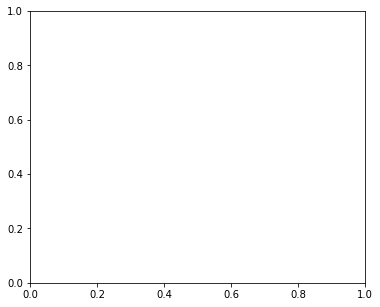

In [54]:
fig = plt.figure(figsize=(6,5))

plt.scatter(y_test,rf_pred,color="blue")
x = np.arange(0, 7)
plt.plot(x,x,color="red")
plt.title("predicted_data & test_data")
plt.xlabel("test_data")
plt.ylabel("predicted_data")

plt.show()

In [55]:
plt.scatter(rf_pred, rf_pred - y_test, color = 'blue')      # 残差をプロット 
plt.hlines(y = 0, xmin = 0, xmax = 7, color = 'black') # x軸に沿った直線をプロット
plt.title('Residual Plot')                                # 図のタイトル
plt.xlabel('Predicted Values')                            # x軸のラベル
plt.ylabel('Residuals')                                   # y軸のラベル
plt.grid()                                                # グリッド線を表示

plt.show()                                               # 図の表示

ValueError: operands could not be broadcast together with shapes (12852,) (4284,) 

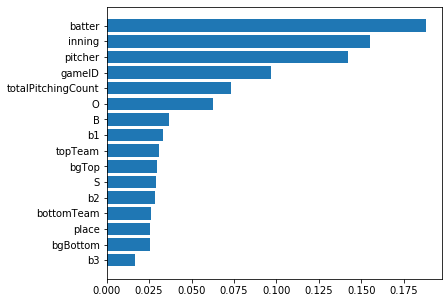

In [1178]:
features = x_train.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,5))
plt.barh(range(len(indices)), importances[indices],  align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

In [1225]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train,y_train)

[19:30:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [1181]:
xgb_pred = xgb_model.predict(x_test)
xgb_pred

XGBoostError: [15:29:20] c:\users\administrator\workspace\xgboost-win64_release_1.4.0\src\data\array_interface.h:139: Check failed: typestr.size() == 3 (2 vs. 3) : `typestr' should be of format <endian><type><size of type in bytes>.

In [1182]:
x_test

,totalPitchingCount,B,S,O,b1,b2,b3,pitcher,batter,gameID,inning,bottomTeam,bgBottom,topTeam,place,bgTop
9146,4,0,2,0,False,False,False,26,29,20202144,14,3,2,9,9,5
5024,5,2,2,2,True,True,True,104,11,20202160,3,9,7,7,3,8
10854,2,1,0,2,True,False,False,77,53,20202138,15,0,3,9,8,5
1246,3,1,1,0,False,False,False,50,188,20202171,5,1,11,8,4,10
7883,1,0,0,0,False,False,False,76,37,20202146,2,4,9,1,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,3,0,2,2,False,False,False,145,219,20202170,7,2,12,3,0,9
246,5,2,2,1,False,False,False,66,43,20202173,17,0,3,6,8,6
4258,2,1,0,1,False,True,False,97,16,20202161,8,0,3,6,8,6
11570,4,1,2,1,True,False,False,108,214,20202135,3,9,7,2,3,12


## Lighht BGM

In [1263]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test)

In [1274]:
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': {'multi_logloss'},
        'num_class': 8,
        'learning_rate': 0.1,
        'num_leaves': 23,
        'min_data_in_leaf': 1,
        'num_iteration': 100,
        'verbose': 0
}

In [1275]:
gbm_model = lgb.train(params,
                      lgb_train,
                      num_boost_round=50,
                      valid_sets=lgb_eval,
                      early_stopping_rounds=10)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's multi_logloss: 1.5233
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.5416
[3]	valid_0's multi_logloss: 1.5514
[4]	valid_0's multi_logloss: 1.5553
[5]	valid_0's multi_logloss: 1.59723
[6]	valid_0's multi_logloss: 1.54361
[7]	valid_0's multi_logloss: 1.54858
[8]	valid_0's multi_logloss: 1.57112
[9]	valid_0's multi_logloss: 1.55136
[10]	valid_0's multi_logloss: 1.6308
[11]	valid_0's multi_logloss: 1.61724
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.5233


In [1283]:
gbm_pred = gbm_model.predict(x_test)
gbm_pred

array([[0.38106201, 0.26182161, 0.18047387, ..., 0.01190133, 0.00063741,
        0.00673511],
       [0.3778106 , 0.26932736, 0.17001433, ..., 0.01151366, 0.00064354,
        0.00651572],
       [0.36393457, 0.28628929, 0.17165465, ..., 0.01108381, 0.00067127,
        0.00679648],
       ...,
       [0.35676037, 0.29078199, 0.17297061, ..., 0.01116878, 0.00067642,
        0.00684858],
       [0.36956152, 0.26624395, 0.17957776, ..., 0.01210235, 0.00067645,
        0.00661911],
       [0.36402778, 0.28636262, 0.17169861, ..., 0.01108665, 0.00064338,
        0.00657016]])

In [1286]:
model = lgb.LGBMClassifier()
model.fit(x_train, y_train)
y_pred = model.predict_proba(x_test)
y_pred_max = np.argmax(y_pred, axis=1)
accuracy = sum(y_test == y_pred_max) / len(y_test)
print(accuracy)

0.3697478991596639


In [1279]:
X=mean_absolute_error(y_test, gbm_pred)
print("LightGBMモデルの平均絶対誤差は",X)
Y=r2_score(y_test, gbm_pred)
print("LightGBMモデルの決定係数は",Y)

ValueError: y_true and y_pred have different number of output (1!=8)

ValueError: x and y must be the same size

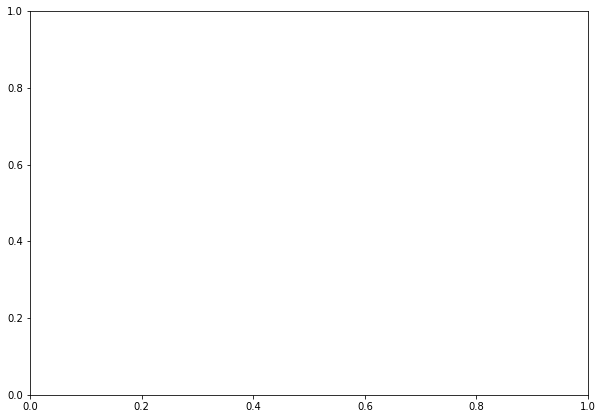

In [1278]:
fig = plt.figure(figsize=(10,24))

ax1 = fig.add_subplot(3, 1, 1)
plt.scatter(y_test,gbm_pred,color="blue")
x = np.arange(0, 7)
plt.plot(x,x,color="red")
plt.title("predicted_data & test_data")
plt.xlabel("test_data")
plt.ylabel("predicted_data")

ax2 = fig.add_subplot(3, 1, 2)
plt.scatter(gbm_pred, gbm_pred - y_test, color = 'blue')      # 残差をプロット 
plt.hlines(y = 0, xmin = 0, xmax = 7, color = 'black') # x軸に沿った直線をプロット
plt.title('Residual Plot')                                # 図のタイトル
plt.xlabel('Predicted Values')                            # x軸のラベル
plt.ylabel('Residuals')                                   # y軸のラベル
plt.grid()                                                # グリッド線を表示


ax3 = fig.add_subplot(3, 1, 3)
features = x_train.columns
importances = gbm_model.feature_importance()
indices = np.argsort(importances)
plt.barh(range(len(indices)),importances[indices],align='center')
plt.yticks(range(len(indices)), features[indices])
plt.title("feature_importances")
plt.xlabel("importance")
plt.ylabel("feature")

plt.show()

In [1234]:
with open('rf_model.txt', mode='wb') as f:
    pickle.dump(rf_model, f)

#with open('xgb_model.txt', mode='wb') as f:
#    pickle.dump(xgb_model, f)
    
with open('gbm_model.txt', mode='wb') as f:
    pickle.dump(gbm_model, f)

## パラメータ調整


In [1235]:
params = {'max_depth':[4,6,8]}


In [1236]:
grid_rf_model = GridSearchCV(
    RandomForestClassifier(random_state=1),
    param_grid=params,
    cv=5,
    scoring = 'r2',
    n_jobs=-1
    )

In [1237]:
grid_rf_model.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=1,
                                   

In [1238]:
grid_rf_model.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [1239]:
with open('grid_rf_model.txt', mode='wb') as f:
    pickle.dump(grid_rf_model.best_estimator_, f)

In [1240]:
gridParams = {
        'max_depth': [4,6,8],
        'learning_rate':[0.1,0.3,0.5],
        'min_data_in_leaf': [15,20,25],
        'num_leaves':[27,31,35]
        }

In [1241]:
fitParams = {'early_stopping_rounds': 10,
              'eval_set': [[x_test, y_test]]}

In [1242]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test)

In [1243]:
grid_gbm_model = GridSearchCV(
    lgb.LGBMRegressor(random_state=1),
    param_grid=gridParams,
    cv=5,
    scoring='r2',
    n_jobs=-1
    )

In [1244]:
grid_gbm_model.fit(
    x_train,
    y_train,
    **fitParams,
    verbose=2)

[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 1.75454
[4]	valid_0's l2: 1.73829
[6]	valid_0's l2: 1.72857
[8]	valid_0's l2: 1.72233
[10]	valid_0's l2: 1.71881
[12]	valid_0's l2: 1.71561
[14]	valid_0's l2: 1.71466
[16]	valid_0's l2: 1.71449
[18]	valid_0's l2: 1.7141
[20]	valid_0's l2: 1.71407
[22]	valid_0's l2: 1.71397
[24]	valid_0's l2: 1.71488
[26]	valid_0's l2: 1.71541
[28]	valid_0's l2: 1.71524
[30]	valid_0's l2: 1.71624
[32]	valid_0's l2: 1.71484
Early stopping, best iteration is:
[22]	valid_0's l2: 1.71397


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=1,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5],
                         'max_depth': [4, 6, 8],
                         'min_data_in_leaf': [15, 20, 25],
                  

In [1245]:
grid_gbm_model.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=25,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=27,
              objective=None, random_state=1, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [1246]:
with open('grid_gbm_model.txt', mode='wb') as f:
    pickle.dump(grid_gbm_model.best_estimator_, f)

##  最適化されたモデルによる予測・評価

In [1247]:
with open('grid_rf_model.txt', mode='rb') as f:
    rf_best_model = pickle.load(f)

In [1248]:
rf_pred = rf_best_model.predict(x_test)
rf_pred

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [1249]:
X=mean_absolute_error(y_test, rf_pred)
print("モデルの平均絶対誤差は",X)
Y=r2_score(y_test, rf_pred)
print("モデルの決定係数は",Y)

モデルの平均絶対誤差は 1.1531279178338
モデルの決定係数は -0.6264464584055935


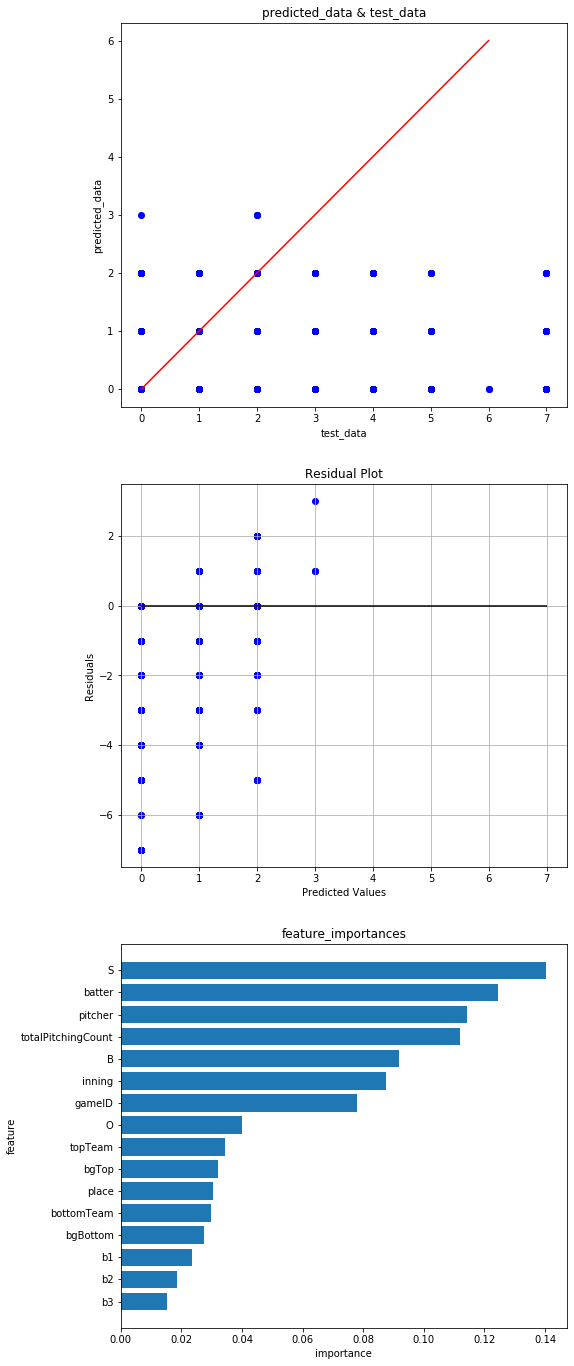

In [1250]:
fig = plt.figure(figsize=(8,24))

ax1 = fig.add_subplot(3, 1, 1)
plt.scatter(y_test,rf_pred,color="blue")
x = np.arange(0, 7)
plt.plot(x,x,color="red")
plt.title("predicted_data & test_data")
plt.xlabel("test_data")
plt.ylabel("predicted_data")

ax2 = fig.add_subplot(3, 1, 2)
plt.scatter(rf_pred, rf_pred - y_test, color = 'blue')      # 残差をプロット 
plt.hlines(y = 0, xmin = 0, xmax = 7, color = 'black') # x軸に沿った直線をプロット
plt.title('Residual Plot')                                # 図のタイトル
plt.xlabel('Predicted Values')                            # x軸のラベル
plt.ylabel('Residuals')                                   # y軸のラベル
plt.grid()                                                # グリッド線を表示


ax3 = fig.add_subplot(3, 1, 3)
features = x_train.columns
importances = rf_best_model.feature_importances_
indices = np.argsort(importances)
plt.barh(range(len(indices)),importances[indices],align='center')
plt.yticks(range(len(indices)), features[indices])
plt.title("feature_importances")
plt.xlabel("importance")
plt.ylabel("feature")

plt.show()


In [1251]:
with open('grid_gbm_model.txt', mode='rb') as f:
    gbm_best_model = pickle.load(f)

In [1252]:
gbm_pred = gbm_best_model.predict(x_test)
gbm_pred

array([1.22277942, 1.39262978, 1.27499404, ..., 1.29450515, 1.33540308,
       1.33659475])

In [1253]:
X=mean_absolute_error(y_test, gbm_pred)
print("モデルの平均絶対誤差は",X)
Y=r2_score(y_test, gbm_pred)
print("モデルの決定係数は",Y)

モデルの平均絶対誤差は 1.0351266347368975
モデルの決定係数は 0.03643277118695831


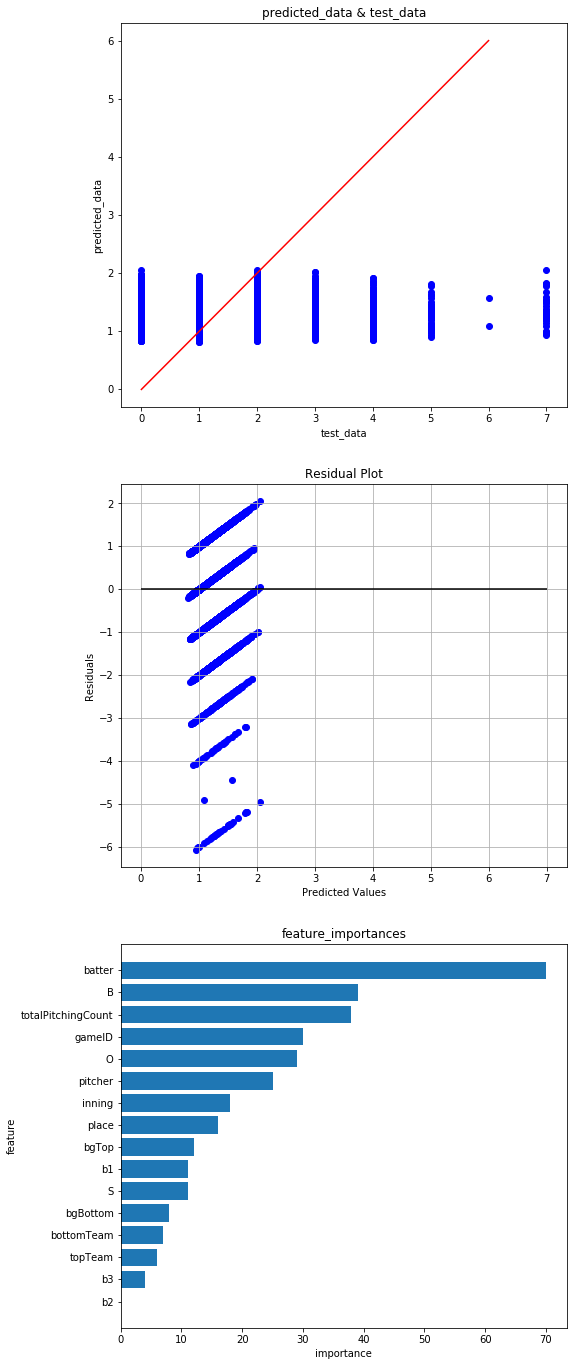

In [1254]:
fig = plt.figure(figsize=(8,24))

ax1 = fig.add_subplot(3, 1, 1)
plt.scatter(y_test,gbm_pred,color="blue")
x = np.arange(0, 7)
plt.plot(x,x,color="red")
plt.title("predicted_data & test_data")
plt.xlabel("test_data")
plt.ylabel("predicted_data")

ax2 = fig.add_subplot(3, 1, 2)
plt.scatter(gbm_pred, gbm_pred - y_test, color = 'blue')      # 残差をプロット 
plt.hlines(y = 0, xmin = 0, xmax = 7, color = 'black') # x軸に沿った直線をプロット
plt.title('Residual Plot')                                # 図のタイトル
plt.xlabel('Predicted Values')                            # x軸のラベル
plt.ylabel('Residuals')                                   # y軸のラベル
plt.grid()                                                # グリッド線を表示


ax3 = fig.add_subplot(3, 1, 3)
features = x_train.columns
importances = gbm_best_model.feature_importances_
indices = np.argsort(importances)
plt.barh(range(len(indices)),importances[indices],align='center')
plt.yticks(range(len(indices)), features[indices])
plt.title("feature_importances")
plt.xlabel("importance")
plt.ylabel("feature")

plt.show()

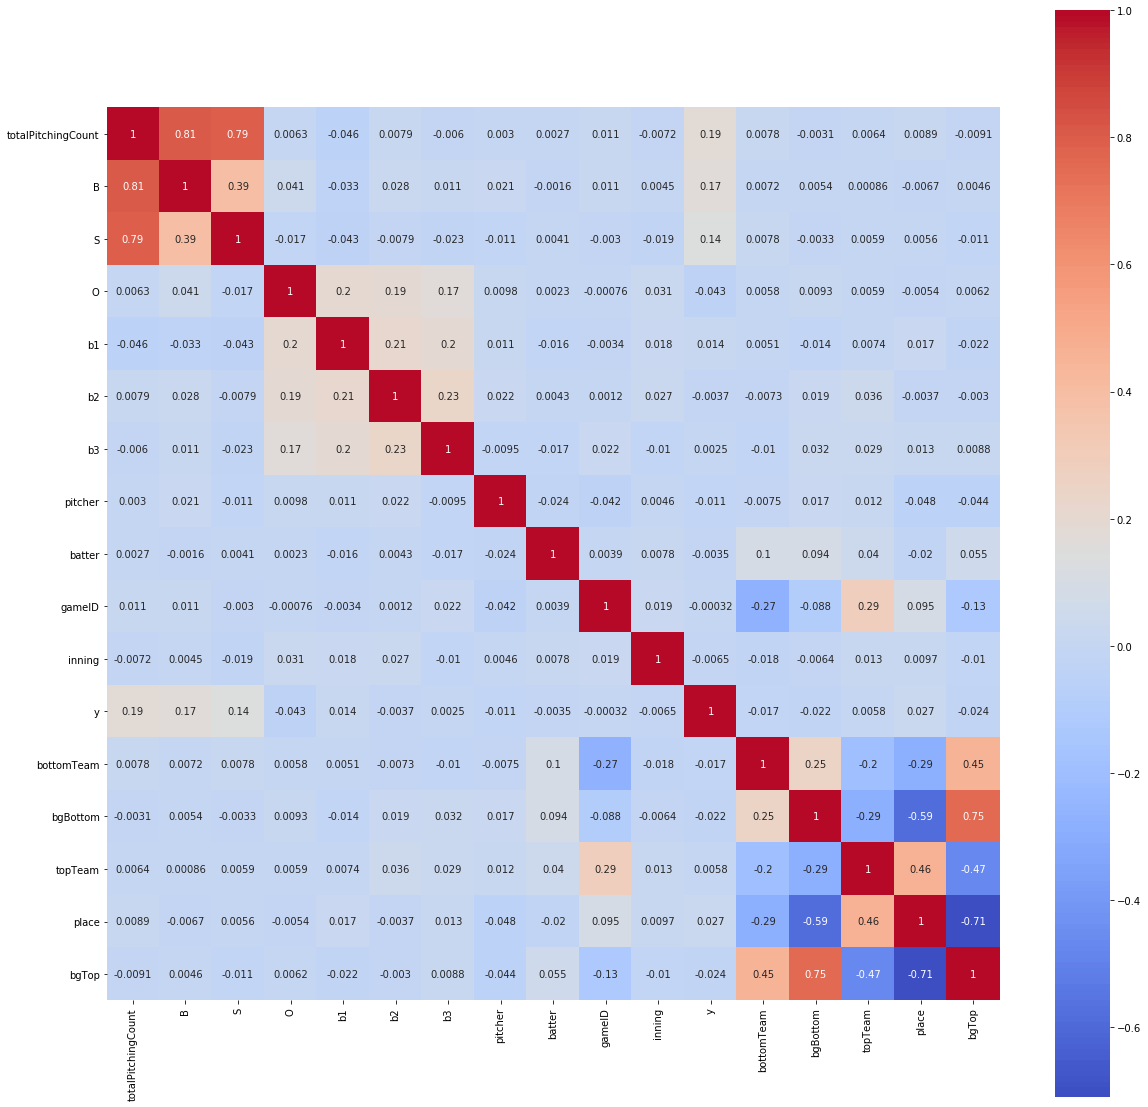

In [1255]:
plt.figure(figsize=(20,20))
corr = imp_data.corr()
cmap = sns.color_palette("coolwarm", 200)
sns.heatmap(corr,xticklabels=corr.columns,
            yticklabels=corr.columns,
            square=True, 
            annot=True,
            cmap=cmap)
plt.show()

In [1260]:
#テスト結果の出力
test_predicted = gbm_model.predict(test)
submit_df = pd.DataFrame({'y': test_predicted})
submit_df.index.name = 'id'
submit_df.to_csv('submission.csv')

In [1259]:
test_X = test[['B', 'S', 'O', 'b1', 'b2', 'b3']]
#テスト結果の出力
test_predicted = gbm_model.predict(test)
submit_df = pd.DataFrame({'y': test_predicted})
submit_df.index.name = 'id'
submit_df.to_csv('submission.csv')